In [2]:
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import numpy as np
import os

# X-ray Pneumonia

## Preprocessing :
- path settings
- split training validation and testing set : 64-16-20
- images to tensor
- label the images
- create dataset (batch datasets)

### path settings

In [3]:
dir_path = 'dataset/chest_xray'
train_path = os.path.join(dir_path,'train')
val_path = os.path.join(dir_path,'val')
test_path = os.path.join(dir_path,'test')

In [4]:
class_names = ['NORMAL', 'PNEUMONIA']
images_path = []

for folder in [train_path, val_path, test_path] :
    for class_ in class_names :
        path = os.path.join(folder, class_)
        image_path = os.listdir(path)
        for image in image_path :
            image_filepath = os.path.join(path,image)
            images_path.append(image_filepath)

In [5]:
# ordinal encoder
labels = [ class_names.index(label.split('\\')[-2]) for label in images_path ]
labels[:5], images_path[:5]

([0, 0, 0, 0, 0],
 ['dataset/chest_xray\\train\\NORMAL\\IM-0410-0001.jpeg',
  'dataset/chest_xray\\train\\NORMAL\\IM-0411-0001.jpeg',
  'dataset/chest_xray\\train\\NORMAL\\IM-0413-0001.jpeg',
  'dataset/chest_xray\\train\\NORMAL\\IM-0414-0001.jpeg',
  'dataset/chest_xray\\train\\NORMAL\\IM-0416-0001.jpeg'])

### split training validation and testing set 

In [6]:
from sklearn.model_selection import train_test_split

X_train_val, X_test, y_train_val, y_test = train_test_split(images_path, labels, test_size=0.2, random_state=42) # test
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42) # train and val

In [7]:
len(X_train), len(X_val), len(X_test)

(3747, 937, 1172)

### images to tensor

In [8]:
def preprocessing(image_path, image_size = (224,224)) :
    '''
    turn image path to tensor with resize image
    '''
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=1) # grayscale 
    image = tf.image.convert_image_dtype(image, dtype=tf.float32) # normalize scale between 0 to 1
    image = tf.image.resize(image, size=image_size)

    return image

### label the images

In [9]:
def get_image_label(image_path, label) :
    '''
    take an image to tensors and resize
    Return image and label tuple
    '''
    image = preprocessing(image_path)
    return image, label

In [10]:
def plot_image(image_tensor, label) :
    '''
    plot 1 images and title with the label
    '''
    plt.figure(figsize=(8,4))
    plt.imshow(image_tensor, cmap='gray')
    plt.title(class_names[label])
    plt.axis('off')
    plt.show()

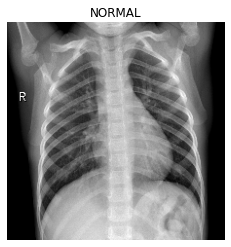

(224, 224, 1) 0


In [11]:
sample_image = 1301
image, label = get_image_label(X_train[sample_image], y_train[sample_image])
plot_image(image, label)
print(image.shape, label)

### create dataset (batch datasets)

In [12]:
BATCH_SIZE = 32

def creat_dataset_batch(X, y=None, batch_size=32, valid_data=False, test_data=False) :
    '''
    create batches of data out of image and label.
    not shuffle in valid and test data ,and y=None because we want to predict it
    '''
    if test_data : # no label because we want to predict it
        print('creating... testing data')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
        data = data.map(preprocessing).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return data
    elif valid_data :
        print('creating... validation data')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
        data = data.map(get_image_label).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return data
    else :
        print('creating... training data')
        data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))).shuffle(len(X)) # shuffle
        data = data.map(get_image_label).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        return data

In [13]:
train_data = creat_dataset_batch(X_train, y_train, batch_size=BATCH_SIZE)
val_data = creat_dataset_batch(X_val, y_val, batch_size=BATCH_SIZE, valid_data=True)
test_data = creat_dataset_batch(X_test, y_test, batch_size=BATCH_SIZE, test_data=True)

creating... training data
creating... validation data
creating... testing data


In [14]:
train_data

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [15]:
test_data # no labels

<PrefetchDataset element_spec=TensorSpec(shape=(None, 224, 224, 1), dtype=tf.float32, name=None)>

In [16]:
# see first databatch
sample_images = []
sample_labels = []
for image, label in train_data.take(1) :
    sample_images.append(image)
    sample_labels.append(label)

In [17]:
sample_images[0].shape, sample_labels[0].shape

(TensorShape([32, 224, 224, 1]), TensorShape([32]))

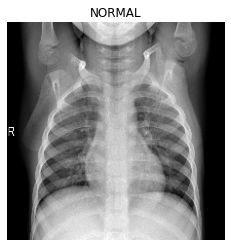

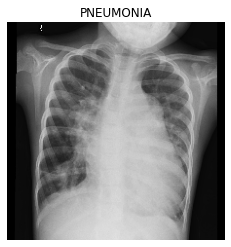

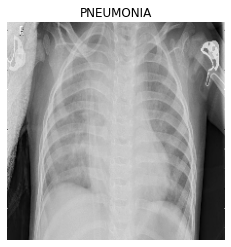

In [18]:
for i in range(3) :
    plot_image(sample_images[0][i], sample_labels[0].numpy()[i])

## Building Model
- evaluate
- predictions
- get better recall

In [244]:
inputs = keras.Input(shape=(224,224,1))
x = keras.layers.Conv2D(filters=16, kernel_size=(5,5), padding='valid')(inputs)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPool2D((2,2))(x)
x = keras.layers.Conv2D(filters=32, kernel_size=(5,5), padding='valid')(x)
x = keras.layers.Activation('relu')(x)
x = keras.layers.MaxPool2D((2,2))(x)
x = keras.layers.Flatten()(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
x_rays_CNN_1_model = keras.Model(inputs = inputs,outputs = outputs, name='x_rays_CNN_1')
x_rays_CNN_1_model.summary()

Model: "x_rays_CNN_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_14 (Conv2D)          (None, 220, 220, 16)      416       
                                                                 
 activation_14 (Activation)  (None, 220, 220, 16)      0         
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 110, 110, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_15 (Conv2D)          (None, 106, 106, 32)      12832     
                                                                 
 activation_15 (Activation)  (None, 106, 106, 32)      0         
                                                      

In [20]:
model_checkpoin_path = 'checkpoint'

In [249]:
opitmizer = keras.optimizers.Adam(learning_rate=0.005)
x_rays_CNN_1_model.compile(loss=keras.losses.BinaryCrossentropy(),
                           optimizer=opitmizer, metrics=['accuracy'])

md_callback = keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_checkpoin_path,'x_rays_CNN_1_model'), monitor='val_loss', save_best_only=True)
el_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=7)
rl_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5)
hist_1 = x_rays_CNN_1_model.fit(train_data, validation_data=val_data, epochs=20, callbacks=[md_callback, el_callback, rl_callback])

Epoch 1/20
118/118 [==============================] - 89s 747ms/step - loss: 0.4317 - accuracy: 0.8209 - val_loss: 0.3536 - val_accuracy: 0.8356 - lr: 0.0050
Epoch 2/20
118/118 [==============================] - 89s 751ms/step - loss: 0.2393 - accuracy: 0.9037 - val_loss: 0.2601 - val_accuracy: 0.9007 - lr: 0.0050
Epoch 3/20
118/118 [==============================] - 85s 723ms/step - loss: 0.1408 - accuracy: 0.9469 - val_loss: 0.1594 - val_accuracy: 0.9456 - lr: 0.0050
Epoch 4/20
118/118 [==============================] - 83s 699ms/step - loss: 0.1015 - accuracy: 0.9597 - val_loss: 0.1474 - val_accuracy: 0.9530 - lr: 0.0050
Epoch 5/20
118/118 [==============================] - 81s 681ms/step - loss: 0.0884 - accuracy: 0.9656 - val_loss: 0.1876 - val_accuracy: 0.9285 - lr: 0.0050
Epoch 6/20
118/118 [==============================] - 80s 680ms/step - loss: 0.0544 - accuracy: 0.9795 - val_loss: 0.2531 - val_accuracy: 0.9285 - lr: 0.0050
Epoch 7/20
118/118 [==============================] 

### evaluate

In [250]:
x_rays_CNN_1_model.evaluate(val_data)

30/30 [==============================] - 5s 163ms/step - loss: 0.2272 - accuracy: 0.9338


[0.22718946635723114, 0.9338313937187195]

In [21]:
# load best model
load_model = keras.models.load_model(os.path.join(model_checkpoin_path,'x_rays_CNN_1_model'))
load_model.evaluate(val_data)

30/30 [==============================] - 6s 179ms/step - loss: 0.1474 - accuracy: 0.9530


[0.14743433892726898, 0.9530416131019592]

### predictions

In [22]:
predictions = load_model.predict(test_data)

In [23]:
predictions.shape, len(y_test)

((1172, 1), 1172)

In [24]:
proba_1 = predictions.copy().reshape(-1,)
y_true = np.array(y_test).reshape(-1,)

In [25]:
pred_class = []
for prob in proba_1 :
    class_ = 1 if prob > 0.5 else 0
    pred_class.append(class_)
pred_class = np.array(pred_class).reshape(-1,)

In [26]:
acc = np.mean(pred_class == y_true)*100 
acc # accuaracy score on test set

94.53924914675767

In [27]:
all_test_images = []
for image in test_data.unbatch().as_numpy_iterator() :
    all_test_images.append(image)

In [28]:
len(all_test_images), len(y_true), len(pred_class)

(1172, 1172, 1172)

In [29]:
all_test_images[0].shape

(224, 224, 1)

In [55]:
def plot_pred_images(images, y_true, pred_class, proba_1) : 
    plt.figure(figsize=(15,15))
    n = np.random.permutation(len(images))[:25]
    for i in range(25) :
        plt.subplot(5,5,i+1)
        plt.imshow(images[n[i]], cmap='gray')
        pred_label_ = class_names[pred_class[n[i]]]
        true_label_ = class_names[y_true[n[i]]]
        proba = proba_1[n[i]]*100 if pred_class[n[i]] == 1 else np.abs(1-proba_1[n[i]])*100
        color = 'blue' if pred_label_ == true_label_ else 'red'
        title = f'{proba:.2f}% {pred_label_} - {true_label_}' if (true_label_ != pred_label_) else f'{proba:.2f}% {pred_label_}'
        plt.title(title, color=color, fontsize=12)
        plt.axis('off')
    plt.suptitle(f'sample ploting test images with {acc:.2f}% accuracy', fontsize=16)
    plt.subplots_adjust(top=0.94)

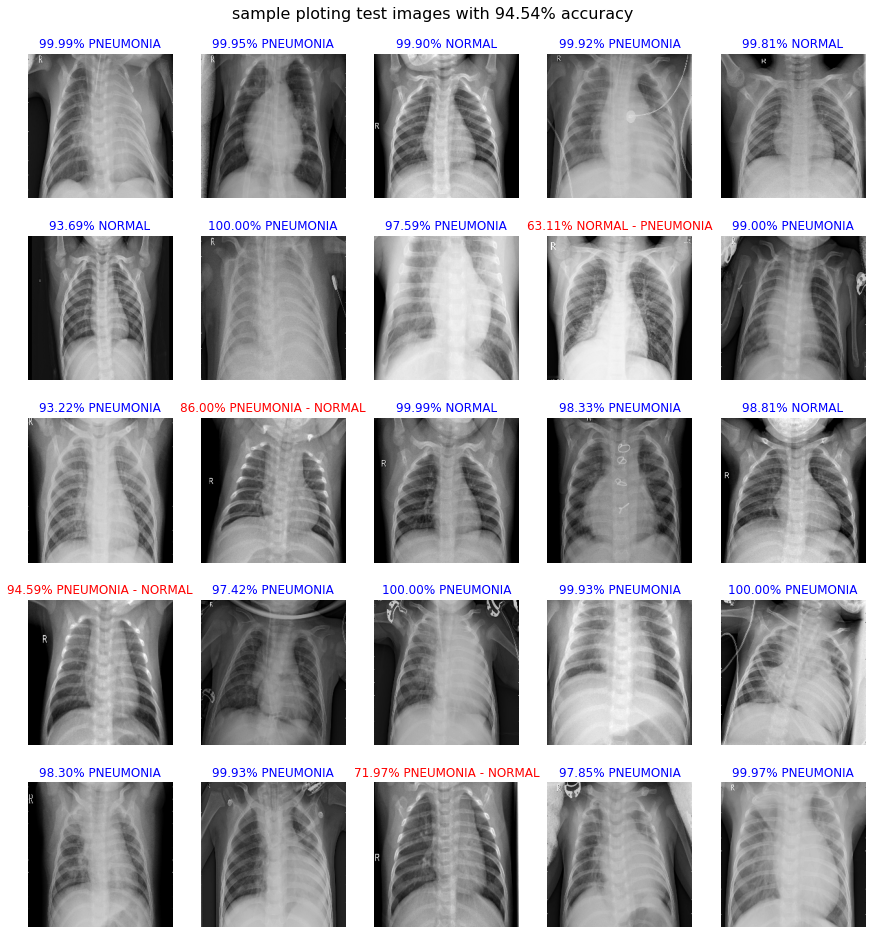

In [162]:
plot_pred_images(all_test_images, y_true, pred_class, proba_1)

### get better recall

In [139]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import classification_report

precisions, recalls, thresholds = precision_recall_curve(y_true, proba_1)

In [129]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.grid()
    plt.legend()

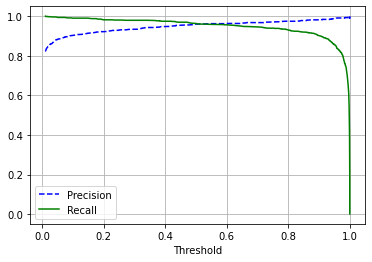

In [130]:
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)

In [131]:
np.argmin(recalls >= 0.97)

164

In [132]:
recalls[163], recalls[164]

(0.9711191335740073, 0.9699157641395909)

In [133]:
thresholds_97_recalls = thresholds[np.argmin(recalls >= 0.97)]
thresholds_97_recalls

0.4416384

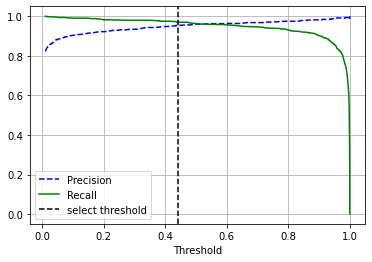

In [147]:
plot_precision_recall_vs_threshold(precisions,recalls,thresholds)
plt.axvline(thresholds_97_recalls, linestyle='--', color='black', label='select threshold')
plt.legend();

> instead of 0.5 (as we set before) to 0.4416384 to improve recall (keep in mind if you want to improve something, another will decrease such as accuary, precision ..)

In [136]:
pred_class_97_recall = (proba_1 >= thresholds_97_recalls)*1
pred_class_97_recall

array([1, 1, 0, ..., 1, 1, 0])

In [137]:
acc_for_recall = np.mean((pred_class_97_recall == y_true))*100
acc - acc_for_recall # but this time accuracy score is the same

0.0

In [150]:
print(classification_report(y_true, pred_class))
print('-- after set a new threshold\n')
print(classification_report(y_true, pred_class_97_recall))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91       341
           1       0.96      0.96      0.96       831

    accuracy                           0.95      1172
   macro avg       0.93      0.93      0.93      1172
weighted avg       0.95      0.95      0.95      1172

-- after set a new threshold

              precision    recall  f1-score   support

           0       0.92      0.89      0.90       341
           1       0.95      0.97      0.96       831

    accuracy                           0.95      1172
   macro avg       0.94      0.93      0.93      1172
weighted avg       0.95      0.95      0.95      1172



> precision decrease after we set a new threshold (because we want to improve recalls)

In [152]:
load_model.save('save_model/x-ray-94acc.h5')